In [0]:
jdbc_url = "jdbc:sqlserver://dataserverformachine.database.windows.net:1433;database=dataformachinelearning;"

# Connection properties including username and password
connection_properties = {
    "user": "*******",           # SQL Server username
    "password": "******",    # SQL Server password
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"  # SQL Server JDBC driver
}

# Read data from the SQL table into a DataFrame
df = spark.read.jdbc(url=jdbc_url, table="dbo.iris_table", properties=connection_properties)

# Show the first few rows of the data
df.show()


+-----------+----------+-----------+----------+-----------+
|SepalLength|SepalWidth|PetalLength|PetalWidth|    Species|
+-----------+----------+-----------+----------+-----------+
|        5.1|       3.5|        1.4|       0.2|Iris-setosa|
|        4.9|       3.0|        1.4|       0.2|Iris-setosa|
|        4.7|       3.2|        1.3|       0.2|Iris-setosa|
|        4.6|       3.1|        1.5|       0.2|Iris-setosa|
|        5.0|       3.6|        1.4|       0.2|Iris-setosa|
|        5.4|       3.9|        1.7|       0.4|Iris-setosa|
|        4.6|       3.4|        1.4|       0.3|Iris-setosa|
|        5.0|       3.4|        1.5|       0.2|Iris-setosa|
|        4.4|       2.9|        1.4|       0.2|Iris-setosa|
|        4.9|       3.1|        1.5|       0.1|Iris-setosa|
|        5.4|       3.7|        1.5|       0.2|Iris-setosa|
|        4.8|       3.4|        1.6|       0.2|Iris-setosa|
|        4.8|       3.0|        1.4|       0.1|Iris-setosa|
|        4.3|       3.0|        1.1|    

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Pipeline

# Index the 'Species' column to convert it into numeric values
indexer = StringIndexer(inputCol="Species", outputCol="indexedSpecies")

# Prepare the data (assemble features into a single vector)
feature_columns = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Split the data into training and test sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=123)

# Initialize the Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="indexedSpecies")

# Build the pipeline
pipeline = Pipeline(stages=[indexer, assembler, lr])

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Show some predictions
predictions.select("Species", "indexedSpecies", "prediction").show()


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

+---------------+--------------+----------+
|        Species|indexedSpecies|prediction|
+---------------+--------------+----------+
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|Iris-versicolor|           0.0|       0.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|    Iris-setosa|           2.0|       2.0|
|Iris-versicolor|           0.0|       0.0|
| Iris-virginica|           1.0|       1.0|
| Iris-virginica|           1.0|       1.0|
|Iris-versicolor|           0.0|       0.0|
|Iris-versicolor|           0.0|       1.0|
|Iris-versicolor|           0.0|

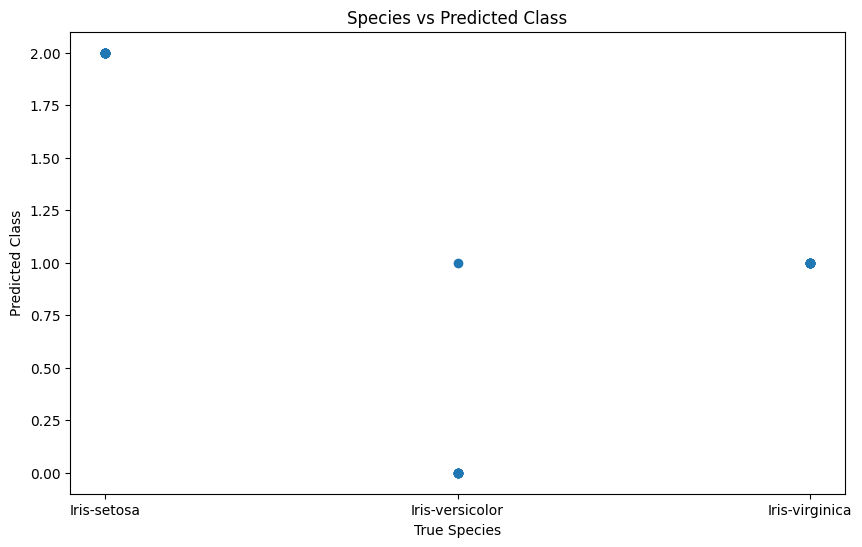

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert predictions to Pandas DataFrame for easy plotting
pred_df = predictions.select("Species", "prediction").toPandas()

# Plot the results
plt.figure(figsize=(10,6))
plt.scatter(pred_df['Species'], pred_df['prediction'])
plt.title('Species vs Predicted Class')
plt.xlabel('True Species')
plt.ylabel('Predicted Class')
plt.show()


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="indexedSpecies", predictionCol="prediction", metricName="accuracy")

# Evaluate the accuracy of the model
accuracy = evaluator.evaluate(predictions)

print(f"Model Accuracy: {accuracy}")


Model Accuracy: 0.9655172413793104


In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Set up the parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.01])
             .addGrid(lr.elasticNetParam, [0.0, 0.5])
             .build())

# CrossValidator setup
crossval = CrossValidator(estimator=pipeline, 
                          estimatorParamMaps=paramGrid, 
                          evaluator=evaluator, 
                          numFolds=3)  # Use 3 folds for cross-validation

# Train the model using cross-validation
cvModel = crossval.fit(train_data)

# Make predictions
cvPredictions = cvModel.transform(test_data)

# Evaluate the tuned model
cvAccuracy = evaluator.evaluate(cvPredictions)
print(f"Cross-Validated Model Accuracy: {cvAccuracy}")


Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/4 [00:00<?, ?it/s]

Cross-Validated Model Accuracy: 0.9655172413793104


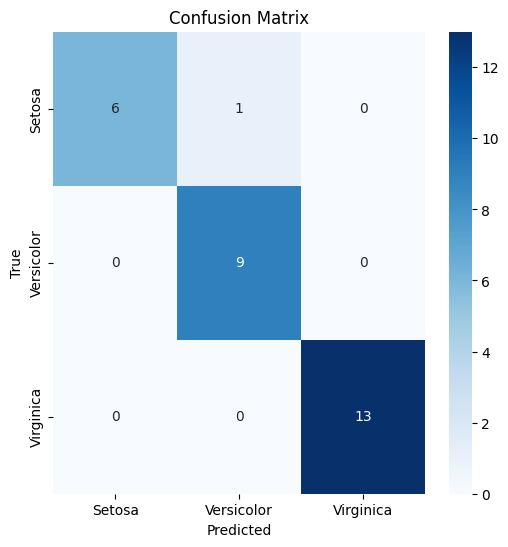

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert the predictions to a Pandas DataFrame for easier plotting
pred_df = cvPredictions.select("indexedSpecies", "prediction").toPandas()

# Compute the confusion matrix
cm = confusion_matrix(pred_df['indexedSpecies'], pred_df['prediction'])

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Setosa", "Versicolor", "Virginica"], yticklabels=["Setosa", "Versicolor", "Virginica"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [0]:
# Save the trained model
cvModel.save("/dbfs/mnt/models/iris_classification_model")
